# Imports

In [120]:
# Imports for data loading
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import ConcatDataset

# Imports for model learning
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

# Other imports
import datetime
# from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights

# Data Loading


Training set size: 23788 images
Test set size: 10192 images

Classes [4]: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


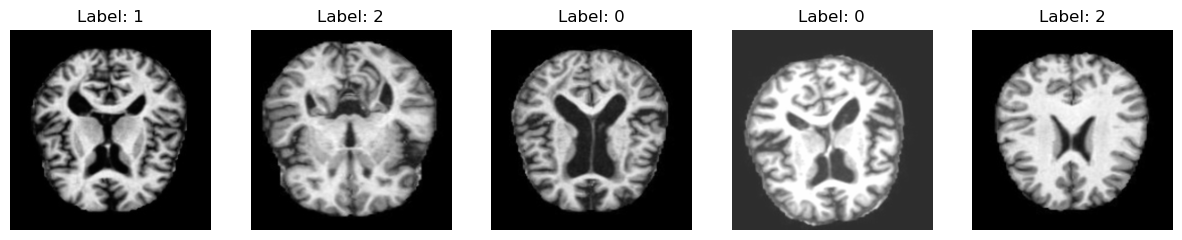

In [ ]:
# Specify paths
TRAIN_PATH = 'dataset/train'
TEST_PATH = 'dataset/test'

# Apply custom transformations
custom_transform = transforms.Compose([
    transforms.Resize((380, 380)),
    transforms.CenterCrop(380),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Grayscale(num_output_channels=3)
    ])
train_dataset = datasets.ImageFolder(root=TRAIN_PATH, transform=custom_transform)
test_dataset = datasets.ImageFolder(root=TEST_PATH, transform=custom_transform)

# Print dataset size
print(f"\nTraining set size: {len(train_dataset)} images")
print(f"Test set size: {len(test_dataset)} images")
class_names = train_dataset.classes
print(f"\nClasses [{len(class_names)}]: {class_names}")

# Show 5 pictures
def show_pictures(dataset: ImageFolder, pictures_num: int=5) -> None:
    start_index = 0

    fig, axes = plt.subplots(nrows=1, ncols=pictures_num, figsize=(15, 45))

    for _, ax in enumerate(axes):
        image, label = dataset[np.random.randint(0, 23787)]
        image = image.permute(1, 2, 0).numpy()
        ax.imshow(image)
        ax.set_title(f"Label: {label}")
        ax.axis("off")
    plt.show()

show_pictures(train_dataset)

# Data Preparation

In [122]:
#transformation = transforms.Compose([
#    transforms.RandomRotation(degrees=10),
#    transforms.Resize(380),
#    transforms.CenterCrop(380),
#    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
#    transforms.ToTensor(),
#    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#])

#train_dataset_transformed = datasets.ImageFolder(root=TRAIN_PATH, transform=transformation)
#test_dataset_transformed = datasets.ImageFolder(root=TEST_PATH, transform=transformation)

In [123]:
#combined_train_dataset = ConcatDataset([train_dataset, train_dataset_transformed])
#combined_test_dataset = ConcatDataset([test_dataset, test_dataset_transformed])

In [124]:
#print(f"Training set size: {len(combined_train_dataset)}")
#print(f"Testing set size: {len(combined_test_dataset)}")

# Transfer Learning

In [125]:
# Check CUDA availability
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [126]:
# Load model
model = torchvision.models.efficientnet_b4(weights=torchvision.models.EfficientNet_B4_Weights.DEFAULT).to(device)

# Set parameter training to False
for param in model.features.parameters():
    param.requires_grad = False

# Define classifier
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=model.classifier[1].in_features,
                    out_features=104,
                    bias=True)).to(device)

# Define loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Settings

In [127]:
# Loading custom weights (CHANGE VERSION EVERY NEW RUN!)
VERSION = 1
if VERSION != 0:
    WEIGHTS_PATH = f"model_weights_v{VERSION}.pt"
    model.load_state_dict(torch.load(WEIGHTS_PATH, weights_only=False))

In [128]:
# Set batch size
batch_size = 38
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [129]:
# Set number of epochs
epochs_num = 10

In [135]:
# Save loss plot
def save_loss_plot(train_loss_array: list, test_loss_array: list) -> None:
    plt.plot(train_loss_array, label="Train Loss", linestyle='-', color='blue', marker='o', markersize=6, linewidth=2)
    plt.plot(test_loss_array, label="Test Loss", linestyle='--', color='orange', marker='s', markersize=6, linewidth=2)

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Loss Graph: v{VERSION+1}", weight='bold')
    plt.legend(loc="upper right", fontsize=12, frameon=True, shadow=True, fancybox=True, borderpad=1)
    #plt.axhline(y=0, color='gray', linestyle='-', linewidth=1, alpha=0.7)

    plt.savefig(f"loss_graph{VERSION+1}.png")

In [ ]:
def save_acc_plot(train_acc_array: list, test_acc_array: list) -> None:
    plt.plot(train_acc_array, label="Train Accuracy", linestyle='-', color='blue', marker='o', markersize=6, linewidth=2)
    plt.plot(test_acc_array, label="Test Accuracy", linestyle='--', color='orange', marker='s', markersize=6, linewidth=2)

    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy Graph: v{VERSION+1}", weight='bold')
    plt.legend(loc="upper right", fontsize=12, frameon=True, shadow=True, fancybox=True, borderpad=1)
    #plt.axhline(y=0, color='gray', linestyle='-', linewidth=1, alpha=0.7)

    plt.savefig(f"acc_graph{VERSION+1}.png")


# Train

In [ ]:
# Statistic for visualisation
train_loss_array = []
test_loss_array = []
train_acc_array = []
test_acc_array = []
best_acc = 0

# Training loop
for epoch in range(epochs_num):
    print(f"Epoch: {epoch}\n---------")

    train_loss, train_acc = 0, 0

    # Train
    model.train()
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (batch % 10 == 0):
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples [{datetime.datetime.now().strftime('%H:%M:%S')}]")

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader.dataset)
    train_loss_array.append(train_loss)
    train_acc_array.append(train_acc)
    test_loss, test_acc = 0, 0

    # Evaluate
    model.eval()
    print(f"Evaluation... [{datetime.datetime.now().strftime('%H:%M:%S')}]")
    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            test_loss += loss_fn(test_pred_logits, y).item()
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item()

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader.dataset)
    test_loss_array.append(test_loss)
    test_acc_array.append(test_acc)

    # Log results of every epoch
    print(f"\nTrain loss: {train_loss:.5f} | Train acc: {((train_acc)*100):.2f}% | Test loss: {test_loss:.5f} | Test acc: {((test_acc)*100):.2f}% [{datetime.datetime.now().strftime('%H:%M:%S')}]\n")
    filename = f"log_v{VERSION+1}.txt"
    with open(filename, "a") as file:
        file.write(f"epoch {epoch}:\nTrain loss: {train_loss:.5f} | Train acc: {((train_acc)*100):.2f}% | Test loss: {test_loss:.5f} | Test acc: {((test_acc)*100):.2f}% [{datetime.datetime.now().strftime('%H:%M:%S')}]\n")

    # Save model with best accuracy
    if test_acc > best_acc:
        best_acc = test_acc
        SAVE_PATH = f"model_best_weights_v{VERSION+1}.pt"
        torch.save(model.state_dict(), SAVE_PATH)

        # Log save
        print(f"\nWeights saved to {SAVE_PATH}")
        with open(filename, "a") as file:
            file.write(f"\nWeights saved to {SAVE_PATH}\n\n")


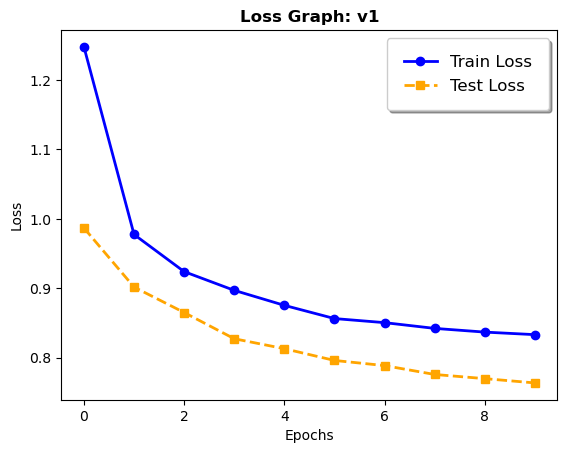

In [136]:
# Plot graph save
save_loss_plot(train_loss_array, test_loss_array)

In [ ]:
# Accuracy graph save
save_acc_plot()

In [134]:
# Weights save
torch.save(model.state_dict(), f"model_weights{VERSION+1}.pt")

In [ ]:
# Model save
#torch.save(model, f"model_file{VERSION+1}.pt")